# Implementación 4: Modelo Support Vector Machines

## Importación de librerias y creación de funciones

In [1]:
# Importar las bibliotecas necesarias
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC  # Para clasificación SVM
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV,ShuffleSplit
from sklearn import tree
from sklearn.metrics import accuracy_score,confusion_matrix,recall_score,precision_score,f1_score
from sklearn.inspection import permutation_importance
from sklearn.inspection import partial_dependence

In [2]:
def cargar_csv(ruta_csv):
    try:
        df = pd.read_csv(ruta_csv)
        return df
    except FileNotFoundError:
        print(f"El archivo en la ruta {ruta_csv} no se encontró.")
    except pd.errors.EmptyDataError:
        print("El archivo CSV está vacío.")
    except pd.errors.ParserError:
        print("Error al analizar el archivo CSV.")
    except Exception as e:
        print(f"Ocurrió un error: {e}")

In [3]:
def export_pickle(objeto, ruta_archivo):
    # Verificar si la ruta del directorio existe, si no, crearla
    directorio = os.path.dirname(ruta_archivo)
    if not os.path.exists(directorio):
        os.makedirs(directorio)

    # Guardar el objeto en un archivo pickle en la ruta especificada
    with open(ruta_archivo, 'wb') as archivo:
        pickle.dump(objeto, archivo)
    print(f'Objeto exportado exitosamente a {ruta_archivo}')

In [4]:
df=cargar_csv(os.path.join('..','Data','output','train_data_1.csv'))

## Desarrollo

### Parametrización

En esta sección se busca parametrizar el desarrollo, dividir el conjunto de datos, definir parámetros de entrenamiento y hacer la creación del pipeline para el modelo

In [5]:
independent_var_erase=['10d'] # Eliminamos la variable de precipitacion acumulada a los 10 dias
dependent_var='deslizamientos'
independent_var=[x for x in df.columns if x not in independent_var_erase and x not in dependent_var]

In [6]:
X=df[independent_var]
y=df[dependent_var]

# Seleccionar columnas categoricas
VAR_categorical_cols = [cname for cname in X.columns if X[cname].dtype == "object"]

# Seleccionar columnas numericas
VAR_numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]

# Total de columnas
VAR_cols = VAR_categorical_cols + VAR_numerical_cols

print('Variables categoricas: ',VAR_categorical_cols)
print('Variables numericas: ',VAR_numerical_cols)
print('Variables independientes: ',VAR_cols)

Variables categoricas:  ['zonificacion', 'Nomenclatura_del_Suelo', 'tipo_geologia']
Variables numericas:  ['ELEVACION', 'PENDIENT', '24h', '7d', '15d', '30d', '60d', '90d']
Variables independientes:  ['zonificacion', 'Nomenclatura_del_Suelo', 'tipo_geologia', 'ELEVACION', 'PENDIENT', '24h', '7d', '15d', '30d', '60d', '90d']


Esto nos indica cuales son las variables que usaremos para el entrenamiento y cuales variables eliminamos, adicionalmente guardamos por separados las variables categóricas y las numéricas para su tratamiento

In [7]:
# Crea un diccionario para los codificadores
label_encoders = {}

for feature in VAR_categorical_cols:
    le = LabelEncoder()
    X[feature] = le.fit_transform(X[feature])
    label_encoders[feature] = le

In [8]:
label_encoders

{'zonificacion': LabelEncoder(),
 'Nomenclatura_del_Suelo': LabelEncoder(),
 'tipo_geologia': LabelEncoder()}

Creamos los codificadores, usaremos `LabelEncoder()` debido a la cantidad de clases que puede tomar cada variable categórica, optimizando recursos computacionales. 

Este objeto nos servirá para codificar valores nuevos que entren al modelo 

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,random_state=23)

In [10]:
shuffle_split = ShuffleSplit(test_size=.3, train_size=.7, n_splits=10)

Como se había explicado en la seccion de Contextualización, usaremos [validación cruzada aleatoria y dividida](intro.md#esquema-de-entrenamiento)

In [11]:
param_grid_svc = {
    'classifier__C': [0.1, 1, 10, 100],             # Valor de regularización
    'classifier__kernel': ['linear', 'rbf', 'poly'], # Tipo de kernel
    'classifier__gamma': [1, 0.1, 0.01, 0.001],      # Coeficiente gamma para rbf/poly
    'classifier__probability': [True]
}

In [12]:
preprocessor_svc = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), VAR_numerical_cols)
    ],
    remainder='passthrough'
)

In [13]:
pipeline_svc= Pipeline([
    ('preprocessor',preprocessor_svc),
    ('classifier', SVC())
])
pipeline_svc

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['ELEVACION', 'PENDIENT',
                                                   '24h', '7d', '15d', '30d',
                                                   '60d', '90d'])])),
                ('classifier', SVC())])

Esto quiere decir que nuestro pipeline encapsula un proceso en el que las columnas numéricas pasan por un proceso de estandarización antes de pasar al modelo

In [14]:
X_train.head()

,ELEVACION,PENDIENT,zonificacion,Nomenclatura_del_Suelo,tipo_geologia,24h,7d,15d,30d,60d,90d
385,1109.965332,42.944015,4,25,7,7.6,83.5,213.5,343.7,452.1,531.0
568,1099.497681,63.939667,1,8,8,1.0,4.4,4.6,31.4,294.2,310.6
50,1096.610596,52.120461,4,25,9,4.0,171.0,315.0,458.0,540.0,698.0
745,1080.625122,46.239780,5,25,9,0.0,18.0,225.0,471.0,753.0,859.0
701,1644.266846,22.834097,5,20,10,0.0,0.2,32.8,98.4,181.0,222.8


In [15]:
y_train.head()

385    1
568    0
50     1
745    1
701    0
Name: deslizamientos, dtype: int64

Así se ve nuestra data de entrenamiento que pasará por el `Pipeline` que se definió

### Rendimiento en Training y Test

La siguiente celda de código junta todas las piezas que definimos previamente, y entrena el modelo de clasificación. Después imprime un mensaje personalizado con el pipeline definido y la combinación de parámetros ganadora

In [16]:
grid_search = GridSearchCV(pipeline_svc, param_grid_svc, cv=shuffle_split,scoring='precision', return_train_score=True)
grid_search.fit(X_train, y_train)
msg_training=f"Support Vector Classifer \n modelo ganador: {grid_search.best_estimator_} \n mejor combinacion de parametros: {grid_search.best_params_}"
print(msg_training)
model_svc=grid_search.best_estimator_

Support Vector Classifer 
 modelo ganador: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['ELEVACION', 'PENDIENT',
                                                   '24h', '7d', '15d', '30d',
                                                   '60d', '90d'])])),
                ('classifier', SVC(C=0.1, gamma=0.1, probability=True))]) 
 mejor combinacion de parametros: {'classifier__C': 0.1, 'classifier__gamma': 0.1, 'classifier__kernel': 'rbf', 'classifier__probability': True}


In [17]:
# Resultados del GridSearchCV
results_svc = grid_search.cv_results_
#  Convertir los resultados en un DataFrame para una mejor visualización
df_results = pd.DataFrame(grid_search.cv_results_)

# Mostrar solo las columnas relevantes
df_results = df_results[['rank_test_score','param_classifier__C','param_classifier__kernel', 'param_classifier__gamma','param_classifier__probability', 'mean_train_score', 'mean_test_score']]
df_results=df_results.rename(columns={'param_classifier__C':'C',
                                      'param_classifier__kernel':'kernel',
                                      'param_classifier__gamma':'gamma',
                                      'param_classifier__probability':'probability',
                                      'mean_train_score':'Rendimiento promedio - Train',
                                      'mean_test_score':'Rendimiento promedio - Test',
                                      'rank_test_score':'Model Ranking'
                                      })
# Ordenar por la mejor puntuación en test
df_sorted = df_results.sort_values(by='Model Ranking', ascending=True)

# Mostrar las primeras 10 filas (los mejores modelos)
df_sorted.head(10)

,Model Ranking,C,kernel,gamma,probability,Rendimiento promedio - Train,Rendimiento promedio - Test
4,1,0.1,rbf,0.1,True,0.950292,0.941953
35,2,10,poly,0.001,True,0.929856,0.933243
28,3,10,rbf,0.1,True,0.991448,0.931614
47,4,100,poly,0.001,True,0.937086,0.928350
8,4,0.1,poly,0.01,True,0.937062,0.928350
40,6,100,rbf,0.1,True,1.000000,0.926453
20,7,1,poly,0.01,True,0.938602,0.923962
19,8,1,rbf,0.01,True,0.928581,0.923375
16,9,1,rbf,0.1,True,0.959679,0.921941
43,10,100,rbf,0.01,True,0.967749,0.920695


Las métricas de rendimiento en el conjunto de entrenamiento y prueba se calculan durante el proceso de búsqueda de hiperparámetros.

En esta tabla podemos ver el top 10 de los modelos que fueron entrenados con los valores de sus parámetros. Como podemos ver, el modelo ganador, es aquel que tiene el valor de `Model Ranking` como 1. Podemos ver su puntaje en Entrenamiento y en Prueba, vemos que tuvo muy buenos puntajes

### Rendimiento en Validation

In [18]:
y_pred_svc = model_svc.predict(X_valid)
precision_svc = precision_score(y_valid, y_pred_svc)
accuracy_svc = accuracy_score(y_valid, y_pred_svc)
recall_svc = recall_score(y_valid, y_pred_svc)
f1_svc = f1_score(y_valid, y_pred_svc)

data_reporte_svc = {
    'Modelo': ['Support Vector Classifer'],
    'Precision': [precision_svc],
    'Recall': [recall_svc],
    'Exactitud': [accuracy_svc],
    'F1-score': [f1_svc]
}

df_reporte_svc = pd.DataFrame(data_reporte_svc)
df_reporte_svc

,Modelo,Precision,Recall,Exactitud,F1-score
0,Support Vector Classifer,0.913978,0.825243,0.863158,0.867347


Al probar el modelo ganador con datos de validación que nunca ha visto, miramos que las métricas se mantienen y son muy buenas

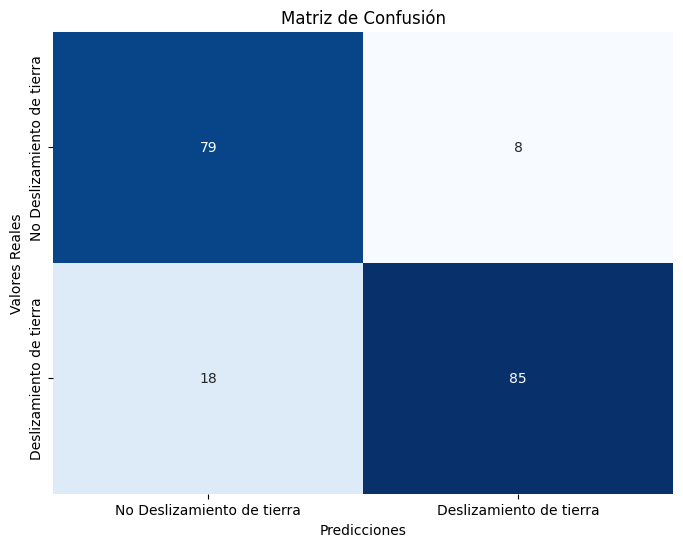

In [19]:
cm = confusion_matrix(y_valid, y_pred_svc)
cm
# Crear el gráfico de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['No Deslizamiento de tierra', 'Deslizamiento de tierra'], yticklabels=['No Deslizamiento de tierra', 'Deslizamiento de tierra'])

# Añadir etiquetas y título
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.title('Matriz de Confusión')
plt.show()

Al mirar la matriz de confusión, nos damos cuenta de que el conteo más bajo es cuando el modelo predice que no habrá deslizamientos, pero en realidad si hubo deslizamiento. Este es el índice que precisamente debemos apuntar a minimizar, porque en la realidad del negocio el costo de actuar sobre un falso positivo es alto, es decir se tiene recursos limitados para manejar casos positivos y se quiere minimizar las consecuencias negativas de las predicciones incorrectas de la clase positiva (falsos positivos). 

In [20]:
train_performance=df_sorted[df_sorted['Model Ranking']==1]['Rendimiento promedio - Train'].values.item()
trest_performance=df_sorted[df_sorted['Model Ranking']==1]['Rendimiento promedio - Test'].values.item()
valid_performance=df_reporte_svc['Precision'].values.item()

Como conclusión tenemos un modelo de clasificación Random Forest con estos puntajes de rendimiento para la medida de Precision

In [21]:
print(f'Precision score en training: {train_performance}')
print(f'Precision score en test: {trest_performance}')
print(f'Precision score en validation: {valid_performance}')

Precision score en training: 0.9502919162166089
Precision score en test: 0.9419530258075437
Precision score en validation: 0.9139784946236559


### Explicabilidad del modelo

Veamos como se comporta el modelo. 

Aunque el modelo SVC no tiene directamente la "importancia de características" como los modelos de árboles, puedes usar métodos alternativos como el `permutation_importance`, este permite evaluar la importancia de las características mediante la permutación de los valores de las mismas:

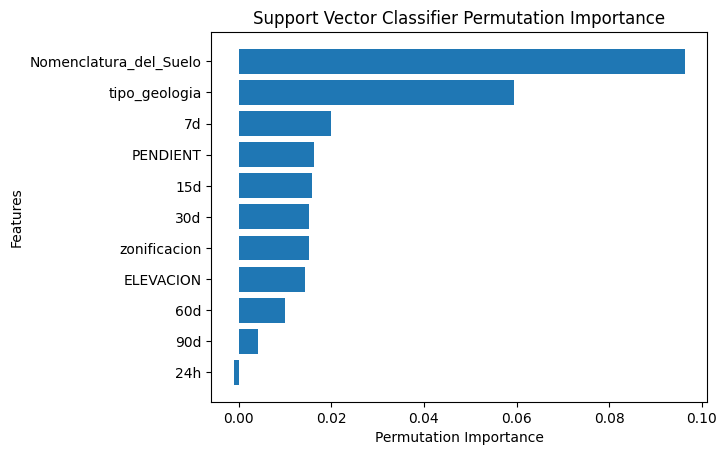

In [22]:
result = permutation_importance(model_svc, X_valid, y_valid, n_repeats=10)
features = X_train.columns
result = np.array(result['importances_mean'])

# Obtener índices de las importancias ordenadas de mayor a menor
indices = np.argsort(result)
# Ordenar importancias y características según el índice
sorted_importances = result[indices]
sorted_features = features[indices]
# Si quieres mostrarlo de manera visual

plt.barh(sorted_features, sorted_importances)
plt.xlabel('Permutation Importance')
plt.ylabel('Features')
plt.title('Support Vector Classifier Permutation Importance')
plt.show()

Podemos observar que se encuentran las características del modelo (features) como `Nomenclatura_del_Suelo`, `tipo_geologia`, `7d`, etc. Están ordenadas de mayor a menor importancia según el resultado del Permutation Importance.

Nomenclatura_del_Suelo: Es la característica más importante del modelo. La barra más larga indica que, cuando se permutaron sus valores, el rendimiento del modelo se deterioró significativamente, lo que sugiere que esta variable tiene un fuerte impacto en las predicciones del modelo SVC.

`tipo_geologia`: Es la segunda característica más importante. Tiene una gran influencia en el rendimiento del modelo, aunque ligeramente menor que `Nomenclatura_del_Suelo`.

`PENDIENT`: Es la tercera en importancia. Aunque no es tan crucial como las dos primeras, aún tiene un impacto considerable en el modelo.

Características intermedias: Estas variables también contribuyen al rendimiento del modelo, pero en menor medida que las tres principales.

Características con menor importancia: Estas características tienen barras muy pequeñas, lo que indica que permutarlas no afectó significativamente el rendimiento del modelo. Esto sugiere que tienen poca o ninguna relevancia en las decisiones que toma el modelo.


Este análisis es útil para entender qué características están impulsando las decisiones del modelo, lo que puede ser clave para realizar ajustes, mejorar interpretabilidad o realizar una posible reducción de dimensionalidad.

Exportamos el modelo:

In [23]:
# En esta celda exportamos el modelo para usarlo posteriormente

model_object={'modelo':model_svc
              ,'encoder':label_encoders}
nombre_modelo='svc-model'
ruta_m=os.path.join('..','Models','output',f'{nombre_modelo}.pkl')
export_pickle(model_object,ruta_m)

Objeto exportado exitosamente a ../Models/output/svc-model.pkl
